### AIF_sprint5_decision_tree
##### この課題の目的
コーディング力を向上させる
スクラッチを通して決定木を理解する
複雑なアルゴリズムの実装に慣れる

#### データセットの用意

In [1]:
import numpy as np  # 線形代数ライブラリー
import pandas as pd  # データの加工, CSVファイルの読み書き
import seaborn as sns  # 描画スタイル変更ライブラリ

In [2]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


#### データセットの理解

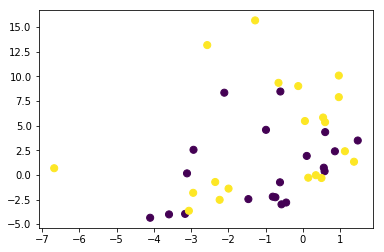

In [3]:
import matplotlib.pyplot as plt  # 描画ライブラリ
%matplotlib inline
plt.scatter(X[:,0], X[:,1], s=50, c=y, marker='o')

### テストデータの分割

学習用（train）8割、検証用（val）2割に分割する。シャッフルは必要ない。

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y)

### 学習

In [5]:
class ScratchDecesionTreeClassifier:
    
    def __init__(self):
        self.X = X
        
    
    # 情報利得（information gain）求める関数
    def _info_gain(self, I_total, I_A, I_B, nodeA_class0, nodeA_class1):

        total_class0 = np.sum(y==0, axis=0)  # 0ラベルの個数
        total_class1 = np.sum(y==1, axis=0)  # 1ラベルの個数

        # ノードA/Bのサンプル数
        nodeA_count = nodeA_class0 + nodeA_class1
        nodeB_count = len(self.X) - nodeA_count

        # 情報利得の算出
        info_gain = I_total - (I_A * ( nodeA_count / len(self.X)) + I_B * ( nodeB_count / len(self.X)))

        return info_gain
    
    # ジニ不純度（ジニ係数）を求める関数
    def _gini_impurity(self, nodeA_class0, nodeA_class1):
        # 全体
        total_count = len(self.X)   # 全体の個数
        total_class0 = np.sum(y==0, axis=0)  # 0ラベルの個数
        total_class1 = np.sum(y==1, axis=0)  # 1ラベルの個数
    
        # ノードAのサンプル数
        nodeA_count = nodeA_class0 + nodeA_class1
    
        # ノードBのサンプル数、class0の数、class1の数
        nodeB_count = total_count - nodeA_count
        nodeB_class0 = total_class0 - nodeA_class0
        nodeB_class1 = total_class1 - nodeA_class1

        # ルートのジニ係数
        I_total = 1 - ((total_class0     / total_count)**2  +  (total_class1 / total_count)**2)

        # ノードAのジニ係数
        if nodeA_count == 0:
            I_A = 0
        else:
            I_A = 1 - ((nodeA_class0 / nodeA_count)**2 + (nodeA_class1 / nodeA_count)**2)

        # ノードBのジニ係数
        if nodeB_count == 0:
            I_B = 0
        else:
            I_B = 1 - ((nodeB_class0 / nodeB_count)**2  + (nodeB_class1 / nodeB_count)**2)

        return I_total, I_A, I_B

    
    # ノード分割する（場合分けする）
    def _divide_nodeA_or_nodeB(self, col):
        ig_box = np.array([])
        
        for i in range(len(self.X)):
        
            # 全体と行を大小比較してTrue/Falseをゲットする！
            nodeA = self.X[:, col] >= self.X[i, col]    
            nodeB = self.X[:, col] < self.X[i, col]

            # ジニ変数を取得する。ここが大事で、とても勉強になった書き方
            I_total, I_A, I_B = self._gini_impurity(np.sum(y[nodeA] == 0, axis=0), np.sum(y[nodeA] == 1, axis=0))
            
            # 情報利得をゲットする
            ig_box = np.append(ig_box, self._info_gain(I_total, I_A, I_B, np.sum(y[nodeA] == 0, axis=0),np.sum(y[nodeA] == 1, axis=0)))
        return ig_box
    
    # 学習する
    def fit(self, X, y):
        ig_box0 = self._divide_nodeA_or_nodeB(0)
        ig_box1 = self._divide_nodeA_or_nodeB(1)

        # X0とX1の情報利得を統合する
        ig_box_all = np.concatenate([ig_box0, ig_box1])

        # 最大の情報利得をもつ値のインデックスを取得する
        max_index = np.argmax(ig_box_all)

        # 商（インデックス（71）÷40） →　カラム
        self.max_index_col = max_index//ig_box0.shape[0]

        # 余り（インデックス（71）÷40） →　列
        self.max_index_i = max_index%ig_box0.shape[0]
        
        # 閾値で分類したnodeA/Bそれぞのノードのクラス（0 or 1）をカウントする
        nA_count = self.X[:, self.max_index_col] >= self.X[self.max_index_i, self.max_index_col]
        nB_count = self.X[:, self.max_index_col] < self.X[self.max_index_i, self.max_index_col]
        #print(nA_count)
        #print(nB_count)
        
        #print(y[nA_count])
        #print(y[nB_count])
        classA0 = np.sum(y[nA_count] == 0, axis=0)
        classA1 = np.sum(y[nA_count] == 1, axis=0)
        
        classB0 = np.sum(y[nB_count] == 0, axis=0)
        classB1 = np.sum(y[nB_count] == 1, axis=0)
        
        
        # 閾値で分けたnodeA,nodeBのクラスを取得する
        if classA0 > classA1:
            self.nodeA_confirm_class = 0
            self.nodeB_confirm_class = 1
        else:
            self.nodeA_confirm_class = 1
            self.nodeB_confirm_class = 0
        
        print("classA0の数   :", classA0)
        #print("classA1の数   :", classA1)
        #print("nodeAのクラス！！　：", self.nodeA_confirm_class)
        
        #print("classB0の数   :", classB0)
        #print("classB1の数   :", classB1)
        #print("nodeBのクラス！！　：", self.nodeB_confirm_class)
        
        print(max_index)
        print("インデックス, カラム：",self.max_index_i, self.max_index_col)
        print("情報利得の最大値", ig_box_all[max_index])
        print("切る位置（＝閾値）", self.X[self.max_index_i, self.max_index_col])
    
    # 予測する
    def predict(self, X):
        
        # 予測結果の枠を作成
        pred = np.zeros(len(X)).astype(int)
        
        # fitで求めた閾値と、予測する列の値を比較する。True,Falseを変数に代入する
        nodeA = X[:, self.max_index_col] >= self.X[self.max_index_i, self.max_index_col]    
        nodeB = X[:, self.max_index_col] < self.X[self.max_index_i, self.max_index_col]
        
        # 
        pred[nodeA] = self.nodeA_confirm_class
        pred[nodeB] = self.nodeB_confirm_class
        # print(pred[nodeA])
        # print(pred[nodeB])
        #pred[nodeB] = self.nodeA_confirm_class
        
        return pred


In [6]:
b = ScratchDecesionTreeClassifier()

In [7]:
b.fit(X, y)

classA0の数   : 2
71
インデックス, カラム： 31 1
情報利得の最大値 0.07680250783699061
切る位置（＝閾値） 5.3524


In [8]:
# インスタンス1作成
sdtc1 = ScratchDecesionTreeClassifier()

# 学習
sdtc1.fit(X, y)
# print("")

# インスタンス2作成
#sdtc2 = ScratchDecesionTreeClassifier()

# 学習
#sdtc2.fit(X_train, y_train)

classA0の数   : 2
71
インデックス, カラム： 31 1
情報利得の最大値 0.07680250783699061
切る位置（＝閾値） 5.3524


In [9]:
# 推論
sdtc1.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1])

### 実行

classA0の数   : 2
71
インデックス, カラム： 31 1
情報利得の最大値 0.07680250783699061
切る位置（＝閾値） 5.3524


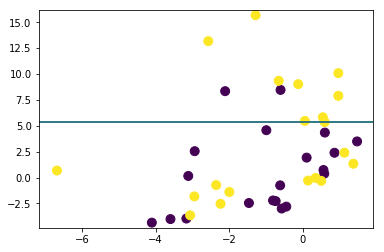

In [10]:
from matplotlib.colors import ListedColormap

# 可視化関数
def plot_decision_regions(X, model):
    plt.scatter(X[:,0], X[:,1], s=80, c=y, marker='o')
    
    #サポートベクターも同様にプロット
    step = 0.1
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)
    plt.contour(mesh_f0, mesh_f1, pred, 1)
    plt.show()
    
tree = ScratchDecesionTreeClassifier()
tree.fit(X, y)
plot_decision_regions(X, tree)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32, 2), (8, 2), (32,), (8,))

In [12]:
XX = pd.DataFrame(X)

XX_train = pd.DataFrame(X_train)
XX_test =  pd.DataFrame(X_test)
yy_train = pd.DataFrame(y_train)
yy_test =  pd.DataFrame(y_test)

In [13]:
XX_test

,0,1
0,0.10645,1.92420
1,0.86291,2.39460
2,-3.06030,-3.64610
3,-2.93620,2.54620
4,-1.99480,-1.39270
5,-2.56770,13.17790
6,-4.10130,-4.35300
7,-2.35300,-0.72261


In [14]:
yy_test

,0
0,0
1,0
2,1
3,0
4,1
5,1
6,0
7,1


In [15]:
XX

,0,1
0,-0.446990,-2.807300
1,-1.462100,-2.458600
2,0.106450,1.924200
3,-3.594400,-4.011200
4,-0.988800,4.571800
5,-3.162500,-3.960600
6,0.564210,0.728880
7,-0.602160,8.463600
8,-0.612510,-0.753450
9,-0.735350,-2.271800


### 説明

### 決定木とは何か
決定木とは、データを分割するルールを次々と作成していくことにより、分類を実行するアルゴリズムです。すなわち、属性とその値の組｛属性1＝値1，属性2＝値2, 属性3＝値3,…，属性n＝値n｝によって表現されたデータをいくつかのクラスと呼ぶものに分類することです。例えば、人事担当者が面接者のデータ{年齢=30, プログラミング経験=あり}などのデータを使って、採用するかしないかを判断するということです。

### ロジスティック回帰やSVMとの違い
ロジスティック回帰分析では、確率を使って数値で表現できる。ロジスティック回帰分析では、低い確率では発生する事を扱える。SVCも、判別分析に適した分布にも適してる。 しかも、正規分布していなくても大丈夫である。一方で、決定木は、データの特徴的な部分をざっくりと見ておきたい時に向いている。 ただ、階層構造を使ってモデルを作るので、階層構造で説明する必要のないデータについては、 上記の2つの手法を使った方が結果の解釈が楽である。


### ジニ不純度とは何か。例えばどのようなときに最大になるか
決定木でデータを分割する時は「クラスをきれいに分けられる」とは逆に「どれだけクラスが混在しているか」という指標を考える。この指標のことをジニ不純度という。
ジニ不純度は、例えば、ノードに含まれるサンプルが均等にちらばっている場合に最大になる。
ジニ不純度以下の式で表される。

#### ジニ不純度の式

$I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})$

t: ノードのインデックス
i: クラスのインデックス
K: クラスの数
Ci　: i番目のクラス
P(Ci|t) :　t番目のノードにおけるCiの割合
Nt,i: t番目のノードのi番目のクラスに属するサンプル数
Nt,all: t番目のノードのサンプルの総数

### 決定木は情報利得をどのように使うことで学習するか
決定木では、トレーニングサンプルのグループであるノードの分岐を繰り返して行くことで分けていくが、分ける前のノードを親ノード、分けた後のノードを子ノードと言う。
親ノードと子ノードの不純度を計算し、その差分である情報利得が最大になるように子ノードを分けていく。
具体的な例で考える。親ノード$D_p$を$2$つの子ノード$D_left$、$D_right$に分けることを考える。
親ノード内のトレーニングサンプルの個数を$N_p$、子ノード内のトレーニングサンプルの個数をそれぞれ$N_left$、$N_right$、また分割する特徴量を$f$とすると、親ノードから子ノードにトレーニングサンプルを分けたときに得られる情報利得は、以下の式で表せる。

#### 情報利得の式

$IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)$

情報利得とはその名の通り、親ノードから子ノードへグループを分けたときにそこから得られる情報量という意味である。不純度は情報量と同じ概念として考えることができるのでこう呼ばれている。
情報利得が最大になるということは子ノードの不純度が最小になるということで、つまり子ノード内のクラスの純度が、より高くなるように分けていく。
親ノードを子ノードに分け更にその子ノードに分け、、を繰り返しそれ以上分ける事が出来なくなったノードをリーフと呼ぶ。木の葉っぱということである。
最後までノード分けを実施してしまうと、過学習状態(新しいサンプルデータに対し汎用性のない分類機になってしまう)に陥ってしまうため、実際は最後までノード分けせずにノード分割する回数(ノードの深さ)のMax値を指定したり、ノード分けで次第に小さくなっていく情報利得に閾値を設けて途中で中断するのが一般的ある。
決定木でノードを分けていく方法は色々あるが、実数の特徴量でトレーニングサンプルを上記の様に2分木に分けていく方法はCART法と呼ばれており、scikit-learnの決定木でも採用されている。